In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from strategy_tester import Backtesting
from sklearn.metrics import classification_report

/home/toyotx22/bitcoin_sentiment_forecaster/tf_venv2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-09-27 17:34:29.151492: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-09-27 17:34:29.151792: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-09-27 17:34:29.232490: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-09-27 17:34:29.391097: I tensorflow/core/platform/cpu_feature_guard.cc:18

In [2]:
def trend_changes_score(y_test: np.array, y_pred: np.array) -> float:
    """
    Calculate the trend changes score based on the test and predicted values.
    
    Args:
        y_test (np.array): True labels.
        y_pred (np.array): Predicted labels.
        
    Returns:
        float: The trend changes score.
    """
    y_df = pd.DataFrame([y_test, y_pred]).T
    y_df.columns = ["y_test", "y_pred"]
    y_df["y_test_shifted"] = y_df["y_test"].shift(-1)
    y_df["is_changed_trend_test"] = y_df["y_test"] != y_df["y_test_shifted"]
    y_df["y_predict_shifted"] = y_df["y_pred"].shift(-1)
    y_df["is_changed_trend_predict"] = y_df["y_pred"] != y_df["y_predict_shifted"]
    return classification_report(
        y_df["is_changed_trend_test"][:-1], 
        y_df["is_changed_trend_predict"][:-1], 
        digits=4
    )

SELECCIÓN DEL MEJOR MODELO PRE-ENTRENADO

In [ ]:
# Leer el archivo de métricas y elegir el mejor modelo
metrics_path = 'data/model_comparison_metrics.csv'
df = pd.read_csv(metrics_path, index_col='model')
best_model_name = df['trend_change_f1_score'].idxmax()
print(f"Mejor modelo según trend_change_f1_score: {best_model_name}")
model = best_model_name

Mejor modelo según trend_change_f1_score: LightGBM


In [4]:
# Cargar datos
train = pd.read_csv("../../data/post_cleaning/training_set.csv", parse_dates=["date"])
val = pd.read_csv("../../data/post_cleaning/validation_set.csv", parse_dates=["date"])
test_set = pd.read_csv("../../data/post_cleaning/test_set.csv", parse_dates=['date'])
# # --- Limitar el test set para pruebas rápidas ---
# n_days_to_test = 20
# test_set = test_set.head(n_days_to_test).copy()
# Concatenar los dataframes de entrenamiento y validación
train_val_set = pd.concat([train, val], ignore_index=True)

CARGA Y PREPARACIÓN DE DATOS

In [5]:
# Preparar los arrays de numpy para la clase Backtesting
# Se pasa el conjunto combinado. La división se hará dentro de la clase Backtesting.
X_train_val = train_val_set.drop(columns=["date", "target_trend"]).values
y_train_val = train_val_set["target_trend"].values
X_test = test_set.drop(columns=['target_trend','date']).values
y_test = test_set['target_trend'].values

Ejecución del Backtesting con Walk-Forward Optimization

In [ ]:
# Configuración de parámetros del backtesting
initial_capital = 10000.0 # Capital inicial para la simulación
window_size = 5 # Número de días en cada ventana de prueba antes de re-optimizar.
optuna_trials_initial_step = 700 # 700 Número de trials de Optuna en el primer paso (más intensivo).
optuna_trials_per_step = 150 # 150 Número de trials para los pasos de re-optimización siguientes.

# Instanciar la clase Backtesting con los datos y la configuración.
bt = Backtesting(
    best_model_name, # Se pasa el nombre del modelo a usar.
    X_train_val, y_train_val, X_test, y_test, test_set,
    window_size=window_size,
    initial_capital=initial_capital,
    optuna_trials_initial=optuna_trials_initial_step,
    optuna_trials=optuna_trials_per_step
)

# Ejecutar el método que contiene toda la lógica del backtesting
# Devuelve el historial de la cartera y métricas clave de la simulación.
backtest_df, trades_df = bt.run()

# Extraer métricas de la estrategia principal para el análisis
num_buys = bt.num_buys_executed
num_sells = bt.num_sells_executed

# Cálculo de los resultados finales de la estrategia principal.
final_portfolio_value = backtest_df['walk_forward_portfolio'].iloc[-1]
total_return_pct = (final_portfolio_value - initial_capital) / initial_capital * 100


Walk-Forward Backtesting:   0%|          | 0/295 [00:00<?, ?it/s][I 2025-09-21 23:55:15,738] A new study created in memory with name: no-name-42981736-45a8-4d9a-84cc-c426d4da3efc
[I 2025-09-21 23:55:17,636] Trial 0 finished with value: 0.4189189189189189 and parameters: {'learning_rate': 0.030710573677773714, 'num_leaves': 97, 'max_depth': 10, 'feature_fraction': 0.8394633936788146, 'bagging_fraction': 0.6624074561769746, 'bagging_freq': 2, 'min_data_in_leaf': 10}. Best is trial 0 with value: 0.4189189189189189.
[I 2025-09-21 23:55:18,051] Trial 1 finished with value: 0.4520547945205479 and parameters: {'learning_rate': 0.13394334706750485, 'num_leaves': 68, 'max_depth': 10, 'feature_fraction': 0.608233797718321, 'bagging_fraction': 0.9879639408647978, 'bagging_freq': 6, 'min_data_in_leaf': 25}. Best is trial 1 with value: 0.4520547945205479.
[I 2025-09-21 23:55:18,514] Trial 2 finished with value: 0.4383561643835616 and parameters: {'learning_rate': 0.017240892195821537, 'num_leaves':


Liquidando posición final de 0.164874 BTC al precio de $105,589.75 en 2025-05-30


In [8]:
print("\n--- Resultados del Backtesting (Walk-Forward Optimization) ---")
print(f"Capital Inicial: ${initial_capital:,.2f}")
print(f"\nValor Final del Portafolio con Walk-Forward Optimization: ${final_portfolio_value:,.2f}")
print(f"Retorno Total de la Estrategia: {total_return_pct:.2f}%")
buy_and_hold_portfolio_value = backtest_df['buy_and_hold_portfolio'].iloc[-1]
buy_and_hold_return_pct = (buy_and_hold_portfolio_value - initial_capital) / initial_capital * 100
print(f"\nValor Final del Portafolio con Estrategia Buy & Hold: ${buy_and_hold_portfolio_value:,.2f}")
print(f"Retorno de Comprar y Mantener (Buy & Hold): {buy_and_hold_return_pct:.2f}%")
dca_portfolio_value = backtest_df['dca_portfolio'].iloc[-1]
dca_return_pct = (dca_portfolio_value - initial_capital) / initial_capital * 100
print(f"\nValor Final del Portafolio con Estrategia Dollar Cost Averaging (DCA): ${dca_portfolio_value:,.2f}")
print(f"Retorno de Dollar Cost Averaging (DCA): {dca_return_pct:.2f}%")


--- Resultados del Backtesting (Walk-Forward Optimization) ---
Capital Inicial: $10,000.00

Valor Final del Portafolio con Walk-Forward Optimization: $17,409.00
Retorno Total de la Estrategia: 74.09%

Valor Final del Portafolio con Estrategia Buy & Hold: $17,117.30
Retorno de Comprar y Mantener (Buy & Hold): 71.17%

Valor Final del Portafolio con Estrategia Dollar Cost Averaging (DCA): $13,273.72
Retorno de Dollar Cost Averaging (DCA): 32.74%


In [ ]:
# Análisis de Operaciones

print("\n--- Análisis de Operaciones Reales ---")
print(f"Número de COMPRAS ejecutadas: {num_buys}")
print(f"Número de VENTAS ejecutadas: {num_sells}")
print(f"Número total de transacciones: {num_buys + num_sells}")

print("\n--- Historial de Operaciones Detallado ---")
print(trades_df)


--- Análisis de Operaciones Reales ---
Número de COMPRAS ejecutadas: 19
Número de VENTAS ejecutadas: 19
Número total de transacciones: 38

--- Historial de Operaciones Detallado ---
   fecha_compra  indice_compra  precio_compra  cantidad_BTC_comprado  \
0    2024-08-23             14       60375.83               0.165629   
1    2024-09-13             35       58132.31               0.168201   
2    2024-09-15             37       59993.02               0.169617   
3    2024-10-13             65       63206.23               0.162755   
4    2024-12-06            119       96945.63               0.160900   
5    2024-12-13            126      100004.29               0.162703   
6    2025-01-04            148       98174.17               0.161522   
7    2025-01-07            151      102235.60               0.155405   
8    2025-01-17            161       99987.30               0.147228   
9    2025-01-19            163      104556.23               0.146554   
10   2025-01-31          

In [10]:
trades_df

,fecha_compra,indice_compra,precio_compra,cantidad_BTC_comprado,fecha_venta,indice_venta,precio_venta,cantidad_BTC_vendido,valor_portafolio_en_venta
0,2024-08-23,14,60375.83,0.165629,2024-08-29,20,59034.90,0.165629,9777.902846
1,2024-09-13,35,58132.31,0.168201,2024-09-14,36,60497.99,0.168201,10175.812188
2,2024-09-15,37,59993.02,0.169617,2024-10-03,55,60649.27,0.169617,10287.123083
3,2024-10-13,65,63206.23,0.162755,2024-12-03,116,95840.61,0.162755,15598.528047
4,2024-12-06,119,96945.63,0.160900,2024-12-12,125,101125.00,0.160900,16270.987653
5,2024-12-13,126,100004.29,0.162703,2024-12-20,133,97461.86,0.162703,15857.326928
6,2025-01-04,148,98174.17,0.161522,2025-01-06,150,98363.61,0.161522,15887.925730
7,2025-01-07,151,102235.60,0.155405,2025-01-11,155,94726.10,0.155405,14720.911713
8,2025-01-17,161,99987.30,0.147228,2025-01-18,162,104077.47,0.147228,15323.098505
9,2025-01-19,163,104556.23,0.146554,2025-01-29,173,101335.52,0.146554,14851.091657


In [ ]:
# Métricas de Clasificación sobre todo el Backtest

# Extraer las predicciones y los valores reales del período de backtesting
y_pred_backtest = backtest_df['signal'].values
y_true_backtest = test_set.loc[backtest_df.index, 'target_trend'].values

print("\n--- Métricas de Clasificación del Backtest Completo ---")

# Reporte de clasificación estándar (predicción de tendencia -1, 0, 1)
print("\nReporte de Clasificación (Tendencia):")
print(classification_report(y_true_backtest, y_pred_backtest, digits=4, zero_division=0))

# Reporte de clasificación de cambio de tendencia (predicción de True/False)
print("\nReporte de Cambio de Tendencia:")
print(trend_changes_score(y_true_backtest, y_pred_backtest))


--- Métricas de Clasificación del Backtest Completo ---

Reporte de Clasificación (Tendencia):
              precision    recall  f1-score   support

          -1     0.7273    0.8800    0.7964       100
           0     0.5000    0.1944    0.2800        36
           1     0.8438    0.8491    0.8464       159

    accuracy                         0.7797       295
   macro avg     0.6903    0.6412    0.6409       295
weighted avg     0.7623    0.7797    0.7603       295


Reporte de Cambio de Tendencia:
              precision    recall  f1-score   support

       False     0.8223    0.8767    0.8486       227
        True     0.4615    0.3582    0.4034        67

    accuracy                         0.7585       294
   macro avg     0.6419    0.6174    0.6260       294
weighted avg     0.7401    0.7585    0.7471       294



GRAFICA CON COMPRAS Y VENTAS

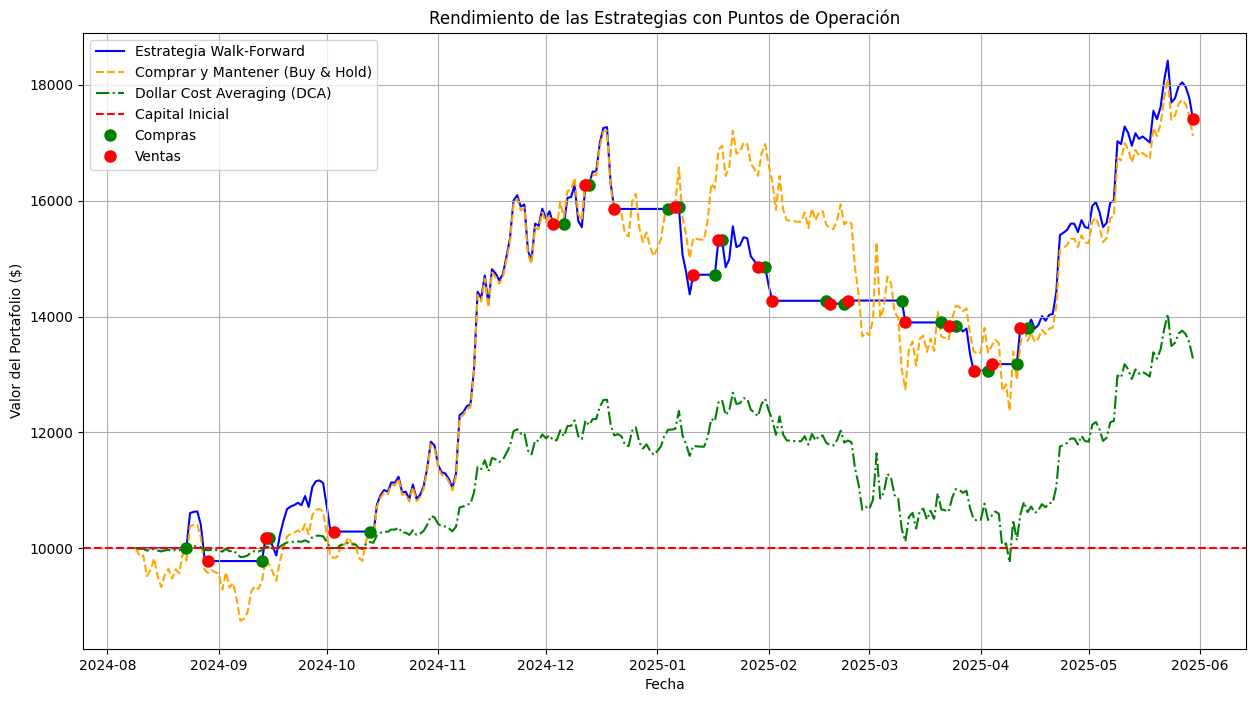

In [ ]:
# Visualización de Resultados
plt.figure(figsize=(15, 8))

# Graficar las 3 estrategias directamente desde el DataFrame de resultados
plt.plot(backtest_df['date'], backtest_df['walk_forward_portfolio'], label='Estrategia Walk-Forward', color='blue', zorder=1)
plt.plot(backtest_df['date'], backtest_df['buy_and_hold_portfolio'], label='Comprar y Mantener (Buy & Hold)', color='orange', linestyle='--')
plt.plot(backtest_df['date'], backtest_df['dca_portfolio'], label='Dollar Cost Averaging (DCA)', color='green', linestyle='-.')

# Añadir línea horizontal para el capital inicial
plt.axhline(y=initial_capital, color='red', linestyle='--', linewidth=1.5, label='Capital Inicial')

# Marcar puntos de compra y venta en la gráfica de la estrategia principal
if not trades_df.empty:
    # Crear un DataFrame temporal para buscar los valores del portafolio en las fechas de las operaciones
    backtest_with_date_index = backtest_df.set_index('date')
    
    # Obtener los datos para los marcadores de compra
    buy_dates = trades_df['fecha_compra'].dropna()
    buy_values = backtest_with_date_index.loc[buy_dates, 'walk_forward_portfolio']
    plt.plot(buy_dates, buy_values, 'go', markersize=8, label='Compras', linestyle='None', zorder=2)

    # Obtener los datos para los marcadores de venta
    sell_dates = trades_df['fecha_venta'].dropna()
    sell_values = backtest_with_date_index.loc[sell_dates, 'walk_forward_portfolio']
    plt.plot(sell_dates, sell_values, 'ro', markersize=8, label='Ventas', linestyle='None', zorder=2)

plt.title('Rendimiento de las Estrategias con Puntos de Operación')
plt.xlabel('Fecha')
plt.ylabel('Valor del Portafolio ($)')
plt.legend()
plt.grid(True)
plt.show()

GRAFICA SENCILLA

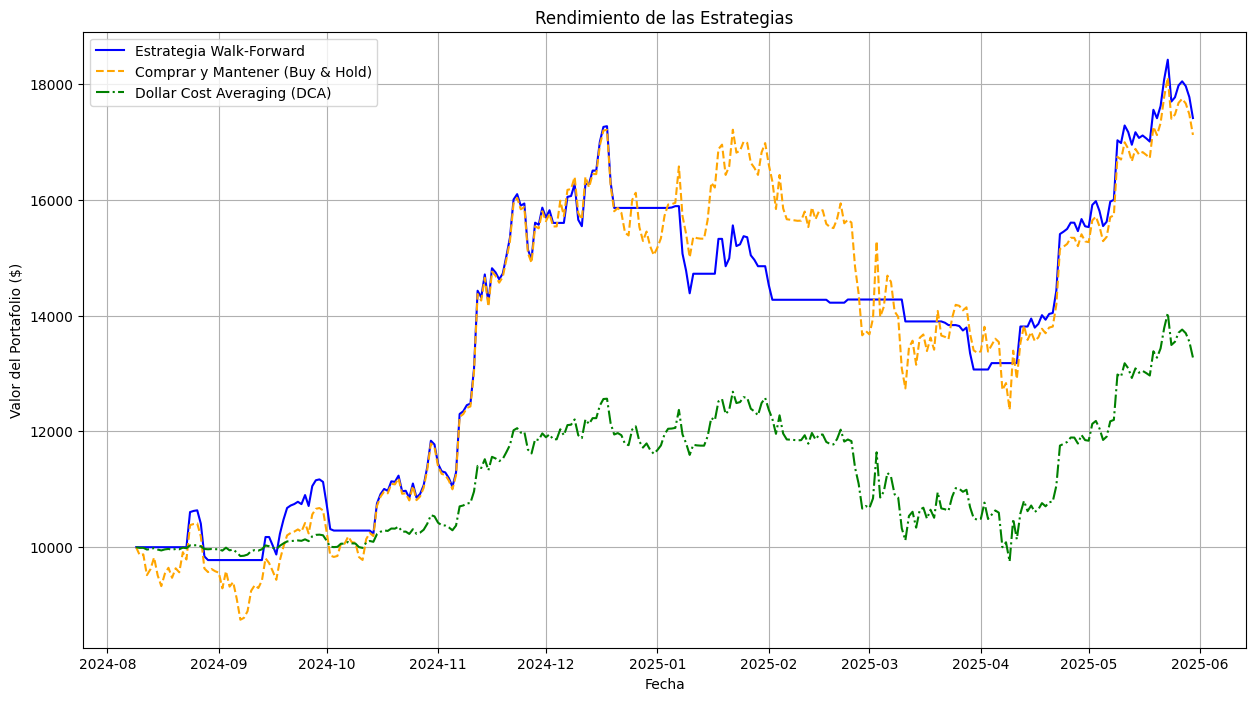

In [ ]:
# Visualización
plt.figure(figsize=(15, 8))

# Graficar las 3 estrategias directamente desde el DataFrame de resultados
plt.plot(backtest_df['date'], backtest_df['walk_forward_portfolio'], label='Estrategia Walk-Forward', color='blue')
plt.plot(backtest_df['date'], backtest_df['buy_and_hold_portfolio'], label='Comprar y Mantener (Buy & Hold)', color='orange', linestyle='--')
plt.plot(backtest_df['date'], backtest_df['dca_portfolio'], label='Dollar Cost Averaging (DCA)', color='green', linestyle='-.')

plt.title('Rendimiento de las Estrategias')
plt.xlabel('Fecha')
plt.ylabel('Valor del Portafolio ($)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Exportar Resultados
# Guardar el historial de operaciones en un archivo CSV para un análisis posterior.
trades_csv_path = 'reports/trades_history.csv'
trades_df.to_csv(trades_csv_path, index=False)

print(f"\nEl historial de operaciones ha sido exportado a: {trades_csv_path}")


El historial de operaciones ha sido exportado a: trades_history.csv


In [15]:
backtest_df

,date,open_d-4,MA_d-4,RSI_d-4,MACD_d-4,trend_d-4,issue_news_d-4,average_news_d-4,sentiment_mean_d-4,sentiment_std_d-4,...,sentiment_skew_d0,sentiment_kurtosis_d0,negative_sentiment_news_d0,positive_sentiment_news_d0,neutral_sentiment_news_d0,target_trend,signal,walk_forward_portfolio,buy_and_hold_portfolio,dca_portfolio
0,2024-08-09,58161.00,64736.641,26.916852,681.042051,-1.0,36.0,0.055556,0.303060,0.183855,...,-0.476336,-1.020108,1.0,5.0,8.0,-1,-1,10000.000000,10000.000000,10000.000000
1,2024-08-10,54018.82,63347.723,20.159090,337.284285,-1.0,25.0,0.320000,0.289227,0.175907,...,-0.889720,-0.146587,3.0,2.0,5.0,-1,-1,10000.000000,9862.527964,9988.543997
2,2024-08-11,56022.00,62160.274,29.649680,-19.007552,-1.0,22.0,0.409091,0.277504,0.161682,...,-0.598884,-1.409191,0.0,0.0,1.0,-1,-1,10000.000000,9876.391726,9989.699310
3,2024-08-12,55133.76,60848.662,28.009323,-378.606124,-1.0,13.0,0.384615,0.281350,0.163938,...,-1.017275,-0.590590,0.0,4.0,9.0,-1,-1,10000.000000,9517.976526,9959.831377
4,2024-08-13,61686.00,60338.794,50.469310,-616.026460,-1.0,14.0,0.285714,0.296589,0.155517,...,-0.665070,-1.110902,1.0,2.0,5.0,0,-1,10000.000000,9620.763220,9968.396935
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290,2025-05-26,109643.99,104927.912,78.320961,3792.846638,1.0,45.0,0.422222,0.329133,0.128724,...,-0.744097,-0.737487,1.0,6.0,15.0,1,1,17971.958914,17670.816717,13702.948444
291,2025-05-27,111696.22,105818.402,81.352864,3879.922064,1.0,31.0,0.161290,0.322185,0.136276,...,-0.729816,-0.740469,1.0,8.0,10.0,1,1,18042.950363,17740.618617,13757.076776
292,2025-05-28,107318.30,106139.860,61.098972,3913.332858,1.0,10.0,0.400000,0.347370,0.123182,...,-0.675033,-0.914311,2.0,13.0,24.0,1,1,17961.072284,17660.112505,13694.647794
293,2025-05-29,107761.90,106565.267,62.159623,3909.514352,1.0,14.0,0.428571,0.356894,0.125633,...,-0.585302,-1.178983,7.0,13.0,25.0,0,1,17770.413634,17472.648575,13549.277684


In [ ]:
backtest_df.to_csv("reports/backtest.csv", index=False)

In [18]:
strategies_df = backtest_df[['date',
                    'walk_forward_portfolio',
                    'buy_and_hold_portfolio', 
                    'dca_portfolio', 
                     ]]

In [ ]:
strategies_df.to_csv("reports/strategies_portfolio.csv", index=False)